# Import packages and load data

In [1]:
import pandas as pd

In [2]:
train = pd.read_csv('train.csv')

## Summarize the continuous variables

In [3]:
train.describe()

PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200

## Examine the first few rows of data

In [4]:
train.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

## Check for missing values
Age will have to be imputed.  Cabin should probably be dropped since so many values are missing.  Rows missing embarked can be dropped since it is only 2 rows.

In [5]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

## Impute Age using median
We could do something fancier using median by group or doing some predictive modeling to fill in the missing age values.

In [6]:
train['ImputedAge'] = train['Age'].fillna(train['Age'].median())
train.head()
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
ImputedAge       0
dtype: int64

## Extract Titles
The Name column is probably useless on it's own but the title associated with each name could be useful.

In [7]:
def get_title(name):
    if '.' in name:
        return name.split(',')[1].split('.')[0].strip()
    else:
        return 'Unknown'
    
train['Title'] = train['Name'].map(lambda x: get_title(x))
train.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  ImputedAge Title  
0      0         A/5 21171   7.2500   NaN        S        22.0    Mr  
1      0          PC 17599  71.2833   C85        C        38.0   Mrs  
2      0  STON/O2. 3101282   7.9250   NaN        S        26.0  Miss  
3      0            113803  53.1000  C123        S        35.0   Mrs  
4      0            373450   8.0500   NaN        S        35.0    Mr

## Drop Age and Cabin
Then check to make sure all remaining data is complete.

In [8]:
train.drop(['Age', 'Cabin'], axis = 1, inplace = True)
train.dropna(inplace = True)
train.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
ImputedAge     0
Title          0
dtype: int64

## Set up data for fitting
Choose which variables to keep, encode categorical variables, and split into a training set and a test set.

In [9]:
from sklearn.model_selection import train_test_split
y = train['Survived']
#keep = ['Sex', 'Pclass', 'Title', 'ImputedAge', 'SibSp', 'Parch', 'Fare']
keep = ['Sex', 'Pclass', 'Title', 'ImputedAge', 'SibSp', 'Parch', 'Fare', 'Embarked']
X = train[keep]
X = pd.get_dummies(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Fit a Logistic Regression model
Fit to the training set.  Score on the test set.

In [10]:
from sklearn.linear_model import LogisticRegression
import sklearn.preprocessing
model = LogisticRegression()
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.8231292517006803

## Use k-fold cross validation

In [11]:
from sklearn.model_selection import cross_val_score
import numpy as np
scores = cross_val_score(model, X, y, cv = 5)
print(scores)
print(np.mean(scores))


[ 0.83707865  0.81460674  0.80337079  0.79213483  0.85310734]
0.820059671174


## Select hyperparameters by cross validation
Choose the level of regularization of the logistic regression by doing a grid search over a set of possible values.

There are multiple ways to quantify the performance of a classification algorithm.  The Kaggle competition for the Titanic dataset uses the prediction accuracy, but it is interesting to consider other metrics.  We consider five different performance metrics:

1. Precision: Correctly identified survivors/total identified survivors.  This is a measure of the quality of the positive results.
2. Recall: Correctly identified survivors/total survivors.  This is a measure of the quantity of the positive results.
3. Accuracy: Fraction of cases correctly identified, whether survivor or not.
4. F1: The F-score is the harmonic mean of precision and recall.
5. AUC: This is the area under the ROC curve.

ROC is the receiver operating characteristic.  The logistic regression produces a probability of survivorship for each person in the dataset.  What probability threshold should we use to predict survivorship?  0.5 may seem logical, but we could use other choices.  The ROC is the relationship between the true positive rate and the false positive rate as the threshold is varied.  The AUC is the area under this curve.

The code block below chooses the best hyperparameters to maximize each of the five metrics in turn.

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report


# Set the parameters by cross-validation
tuned_parameters = [{'penalty': ['l1', 'l2'], 'C': [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100, 300, 1000]}]

scores = ['precision', 'recall', 'accuracy', 'f1', 'roc_auc']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(model, tuned_parameters, cv=5,
                       scoring=score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'C': 0.01, 'penalty': 'l2'}

Grid scores on development set:

0.634 (+/-0.170) for {'C': 0.01, 'penalty': 'l1'}
0.849 (+/-0.105) for {'C': 0.01, 'penalty': 'l2'}
0.773 (+/-0.257) for {'C': 0.03, 'penalty': 'l1'}
0.765 (+/-0.048) for {'C': 0.03, 'penalty': 'l2'}
0.747 (+/-0.039) for {'C': 0.1, 'penalty': 'l1'}
0.769 (+/-0.046) for {'C': 0.1, 'penalty': 'l2'}
0.775 (+/-0.028) for {'C': 0.3, 'penalty': 'l1'}
0.796 (+/-0.041) for {'C': 0.3, 'penalty': 'l2'}
0.804 (+/-0.045) for {'C': 1, 'penalty': 'l1'}
0.796 (+/-0.050) for {'C': 1, 'penalty': 'l2'}
0.794 (+/-0.049) for {'C': 3, 'penalty': 'l1'}
0.792 (+/-0.054) for {'C': 3, 'penalty': 'l2'}
0.788 (+/-0.055) for {'C': 10, 'penalty': 'l1'}
0.791 (+/-0.052) for {'C': 10, 'penalty': 'l2'}
0.792 (+/-0.064) for {'C': 30, 'penalty': 'l1'}
0.781 (+/-0.062) for {'C': 30, 'penalty': 'l2'}
0.792 (+/-0.064) for {'C': 100, 'penalty': 'l1'}
0.788 (+/-0.055) for {'C

The hyperparameters that maximize the AUC:

In [13]:
clf.best_params_

{'C': 3, 'penalty': 'l2'}

## Plot ROC
Using the choice of hyperparameters that optimize the AUC we plot the ROC for using cross validation.

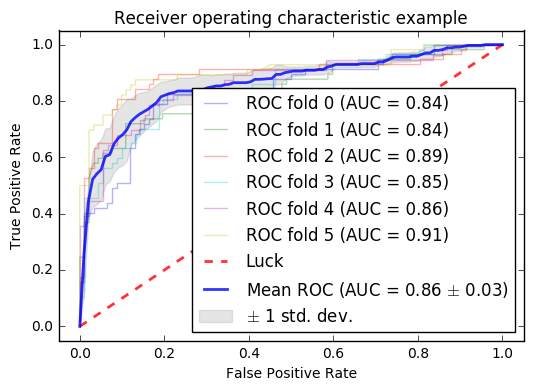

In [14]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
import numpy as np
cv = StratifiedKFold(n_splits=6)
classifier = LogisticRegression(**clf.best_params_)
X = X.as_matrix()
y = y.as_matrix()

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(X, y):
    #print(X[train])
    probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Bundle previous steps into a single function

In [15]:
from sklearn.svm import SVC
def run_steps(X, y, model_f, tuned_parameters):
    model = model_f()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    model.fit(X_train, y_train)
    print("Score on test using default settings: ", model.score(X_test, y_test))
    scores = cross_val_score(model, X, y, cv = 5)
    print("Scores for 5 fold CV: ", scores)
    print("Mean score for 5 fold CV: ", np.mean(scores))
    
    #tuned_parameters = [{'penalty': ['l1', 'l2'], 'C': [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100, 300, 1000]}]

    scores = ['precision', 'recall', 'accuracy', 'f1', 'roc_auc']
    #scores = ['recall', 'accuracy', 'f1', 'roc_auc']

    for score in scores:
        print("# Tuning hyper-parameters for %s" % score)
        print()

        clf = GridSearchCV(model, tuned_parameters, cv=5,
                       scoring=score)
        clf.fit(X_train, y_train)

        print("Best parameters set found on development set:")
        print()
        print(clf.best_params_)
        print()
        print("Grid scores on development set:")
        print()
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
        print()

        print("Detailed classification report:")
        print()
        print("The model is trained on the full development set.")
        print("The scores are computed on the full evaluation set.")
        print()
        y_true, y_pred = y_test, clf.predict(X_test)
        print(classification_report(y_true, y_pred))
        print()
        
    print("Best settings for ", scores[-1], ":", clf.best_params_)
    
    cv = StratifiedKFold(n_splits=6)
    if (model_f == SVC):
        classifier = model_f(**clf.best_params_, probability = True)
    else:
        classifier = model_f(**clf.best_params_)
    #X = X.as_matrix()
    #y = y.as_matrix()

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    i = 0
    for train, test in cv.split(X, y):
        #print(X[train])
        probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

## Logistic Regression

Score on test using default settings:  0.823129251701
Scores for 5 fold CV:  [ 0.83707865  0.81460674  0.80337079  0.79213483  0.85310734]
Mean score for 5 fold CV:  0.820059671174
# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'C': 0.01, 'penalty': 'l2'}

Grid scores on development set:

0.634 (+/-0.170) for {'C': 0.01, 'penalty': 'l1'}
0.849 (+/-0.105) for {'C': 0.01, 'penalty': 'l2'}
0.773 (+/-0.257) for {'C': 0.03, 'penalty': 'l1'}
0.765 (+/-0.048) for {'C': 0.03, 'penalty': 'l2'}
0.747 (+/-0.039) for {'C': 0.1, 'penalty': 'l1'}
0.769 (+/-0.046) for {'C': 0.1, 'penalty': 'l2'}
0.775 (+/-0.028) for {'C': 0.3, 'penalty': 'l1'}
0.796 (+/-0.041) for {'C': 0.3, 'penalty': 'l2'}
0.804 (+/-0.045) for {'C': 1, 'penalty': 'l1'}
0.796 (+/-0.050) for {'C': 1, 'penalty': 'l2'}
0.794 (+/-0.049) for {'C': 3, 'penalty': 'l1'}
0.792 (+/-0.054) for {'C': 3, 'penalty': 'l2'}
0.788 (+/-0.055) for {'C': 10, 'penalty': 'l1'}
0.791 (+/-0.052) for {'C': 10, 'pena

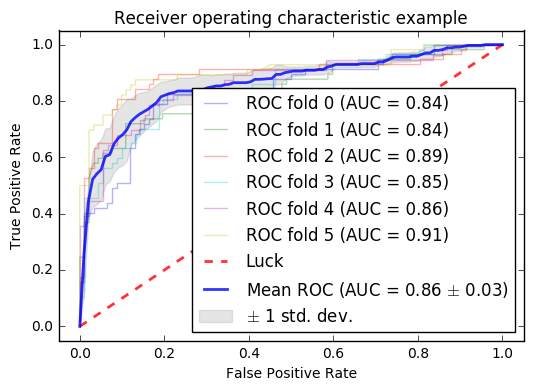

In [16]:
model = LogisticRegression
tuned_parameters = [{'penalty': ['l1', 'l2'], 'C': [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100, 300, 1000]}]
run_steps(X, y, model, tuned_parameters)

## K Neighbors Classifier

Score on test using default settings:  0.710884353741
Scores for 5 fold CV:  [ 0.67977528  0.7247191   0.75280899  0.73033708  0.73446328]
Mean score for 5 fold CV:  0.724420745255
# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'metric': 'manhattan', 'n_neighbors': 2}

Grid scores on development set:

0.636 (+/-0.130) for {'metric': 'euclidean', 'n_neighbors': 1}
0.731 (+/-0.062) for {'metric': 'euclidean', 'n_neighbors': 2}
0.661 (+/-0.097) for {'metric': 'euclidean', 'n_neighbors': 3}
0.680 (+/-0.107) for {'metric': 'euclidean', 'n_neighbors': 4}
0.648 (+/-0.114) for {'metric': 'euclidean', 'n_neighbors': 5}
0.670 (+/-0.123) for {'metric': 'euclidean', 'n_neighbors': 6}
0.619 (+/-0.216) for {'metric': 'euclidean', 'n_neighbors': 7}
0.643 (+/-0.145) for {'metric': 'euclidean', 'n_neighbors': 8}
0.635 (+/-0.148) for {'metric': 'euclidean', 'n_neighbors': 9}
0.662 (+/-0.175) for {'metric': 'euclidean', 'n_neighbors': 10}
0.687 (+/-0.110) for {'m

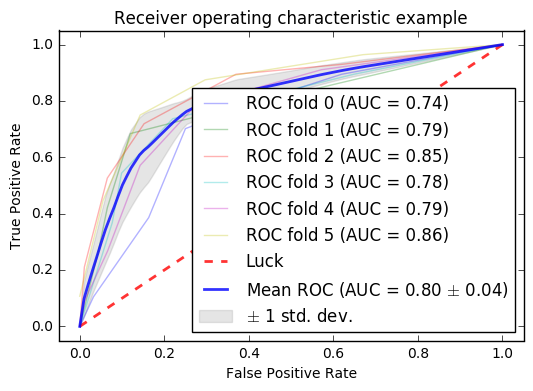

In [21]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier
tuned_parameters = [{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'metric': ['euclidean', 'manhattan', 'chebyshev']}]
run_steps(X, y, model, tuned_parameters)

## Support Vector Classifier

Score on test using default settings:  0.748299319728
Scores for 5 fold CV:  [ 0.6741573   0.73595506  0.73595506  0.76404494  0.76271186]
Mean score for 5 fold CV:  0.734564844791
# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'kernel': 'linear', 'C': 1}

Grid scores on development set:

0.764 (+/-0.031) for {'kernel': 'linear', 'C': 0.03}
0.784 (+/-0.030) for {'kernel': 'linear', 'C': 0.1}
0.786 (+/-0.035) for {'kernel': 'linear', 'C': 0.3}
0.787 (+/-0.026) for {'kernel': 'linear', 'C': 1}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.85      0.85      0.85       184
          1       0.75      0.75      0.75       110

avg / total       0.82      0.82      0.82       294


# Tuning hyper-parameters for recall

Best parameters set found on development set:

{'kernel': 'linear', 'C

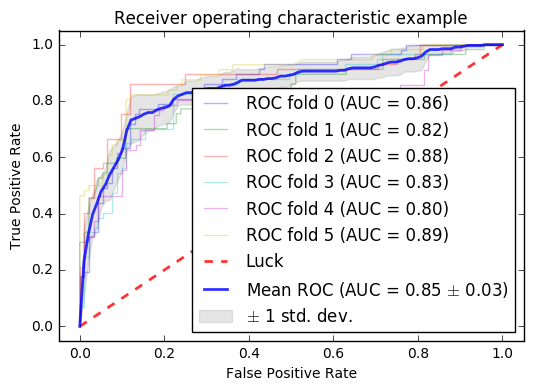

In [22]:
from sklearn.svm import SVC
model = SVC
tuned_parameters = [{'kernel': ['linear'], 'C': [0.03, 0.1, 0.3, 1]}]
run_steps(X, y, model, tuned_parameters)

## Gaussian Process Classifier

Score on test using default settings:  0.697278911565
Scores for 5 fold CV:  [ 0.71348315  0.71348315  0.76404494  0.74719101  0.73446328]
Mean score for 5 fold CV:  0.734533104805
# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'n_restarts_optimizer': 1}

Grid scores on development set:

0.675 (+/-0.066) for {'n_restarts_optimizer': 1}
0.675 (+/-0.066) for {'n_restarts_optimizer': 2}
0.675 (+/-0.066) for {'n_restarts_optimizer': 3}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.74      0.80      0.77       184
          1       0.61      0.52      0.56       110

avg / total       0.69      0.70      0.69       294


# Tuning hyper-parameters for recall

Best parameters set found on development set:

{'n_restarts_optimizer': 1}

Grid scores on development set:

0.574 (+/-0.136) for {

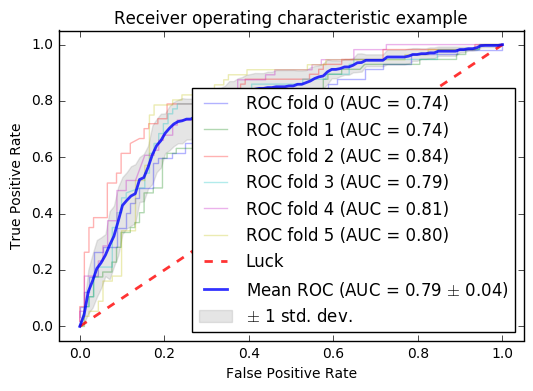

In [23]:
from sklearn.gaussian_process import GaussianProcessClassifier
model = GaussianProcessClassifier
tuned_parameters = [{'n_restarts_optimizer': [1, 2, 3]}]
run_steps(X, y, model, tuned_parameters)

## Decision Tree Classifier

Score on test using default settings:  0.741496598639
Scores for 5 fold CV:  [ 0.76966292  0.76404494  0.84831461  0.71910112  0.79096045]
Mean score for 5 fold CV:  0.778416809497
# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'max_depth': 2, 'splitter': 'best', 'criterion': 'gini'}

Grid scores on development set:

0.710 (+/-0.059) for {'max_depth': 1, 'splitter': 'best', 'criterion': 'gini'}
0.710 (+/-0.059) for {'max_depth': 1, 'splitter': 'random', 'criterion': 'gini'}
0.870 (+/-0.240) for {'max_depth': 2, 'splitter': 'best', 'criterion': 'gini'}
0.777 (+/-0.209) for {'max_depth': 2, 'splitter': 'random', 'criterion': 'gini'}
0.775 (+/-0.087) for {'max_depth': 3, 'splitter': 'best', 'criterion': 'gini'}
0.788 (+/-0.075) for {'max_depth': 3, 'splitter': 'random', 'criterion': 'gini'}
0.803 (+/-0.138) for {'max_depth': 4, 'splitter': 'best', 'criterion': 'gini'}
0.812 (+/-0.055) for {'max_depth': 4, 'splitter': 'random', 'criterion': 'gini'}

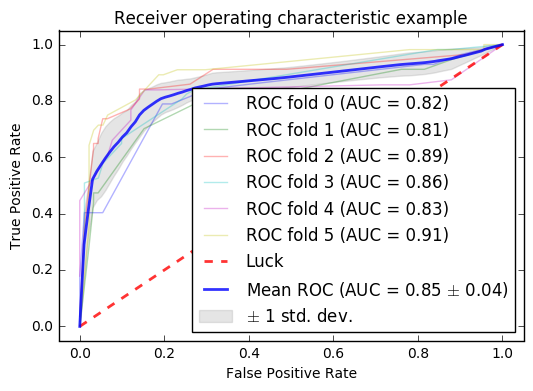

In [24]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier
tuned_parameters = [{'criterion': ['gini', 'entropy'], 
                     'splitter': ['best', 'random'], 
                     'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}]
run_steps(X, y, model, tuned_parameters)

## Random Forest Classifier

Score on test using default settings:  0.785714285714
Scores for 5 fold CV:  [ 0.7752809   0.79775281  0.83707865  0.74157303  0.82485876]
Mean score for 5 fold CV:  0.795308830064
# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'max_depth': 7, 'n_estimators': 20, 'criterion': 'entropy'}

Grid scores on development set:

0.812 (+/-0.166) for {'max_depth': 1, 'n_estimators': 10, 'criterion': 'gini'}
0.748 (+/-0.006) for {'max_depth': 1, 'n_estimators': 20, 'criterion': 'gini'}
0.740 (+/-0.027) for {'max_depth': 1, 'n_estimators': 30, 'criterion': 'gini'}
0.810 (+/-0.171) for {'max_depth': 2, 'n_estimators': 10, 'criterion': 'gini'}
0.755 (+/-0.020) for {'max_depth': 2, 'n_estimators': 20, 'criterion': 'gini'}
0.733 (+/-0.068) for {'max_depth': 2, 'n_estimators': 30, 'criterion': 'gini'}
0.794 (+/-0.059) for {'max_depth': 3, 'n_estimators': 10, 'criterion': 'gini'}
0.816 (+/-0.065) for {'max_depth': 3, 'n_estimators': 20, 'criterion': 'gini'}
0.77

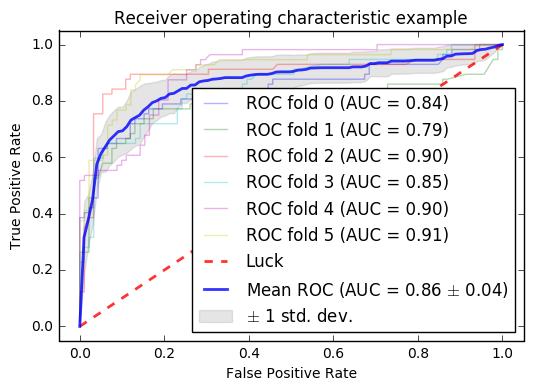

In [25]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier
tuned_parameters = [{'n_estimators': [10, 20, 30],
                     'criterion': ['gini', 'entropy'], 
                     'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]}]
run_steps(X, y, model, tuned_parameters)

## Extra Trees Classifier

Score on test using default settings:  0.751700680272
Scores for 5 fold CV:  [ 0.79213483  0.74719101  0.83146067  0.74157303  0.79096045]
Mean score for 5 fold CV:  0.780664000508
# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'max_depth': 9, 'n_estimators': 30, 'criterion': 'entropy'}

Grid scores on development set:

0.775 (+/-0.073) for {'max_depth': 1, 'n_estimators': 10, 'criterion': 'gini'}
0.782 (+/-0.135) for {'max_depth': 1, 'n_estimators': 20, 'criterion': 'gini'}
0.748 (+/-0.006) for {'max_depth': 1, 'n_estimators': 30, 'criterion': 'gini'}
0.758 (+/-0.027) for {'max_depth': 2, 'n_estimators': 10, 'criterion': 'gini'}
0.757 (+/-0.013) for {'max_depth': 2, 'n_estimators': 20, 'criterion': 'gini'}
0.750 (+/-0.008) for {'max_depth': 2, 'n_estimators': 30, 'criterion': 'gini'}
0.762 (+/-0.016) for {'max_depth': 3, 'n_estimators': 10, 'criterion': 'gini'}
0.763 (+/-0.024) for {'max_depth': 3, 'n_estimators': 20, 'criterion': 'gini'}
0.76

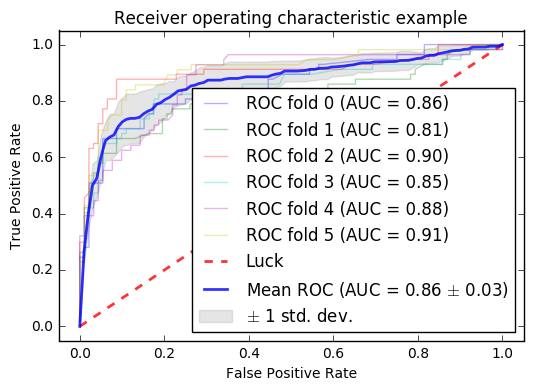

In [26]:
from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier
tuned_parameters = [{'n_estimators': [10, 20, 30],
                     'criterion': ['gini', 'entropy'], 
                     'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]}]
run_steps(X, y, model, tuned_parameters)

## Multi-Layer Perceptron Classifier

Score on test using default settings:  0.809523809524
Scores for 5 fold CV:  [ 0.80337079  0.80898876  0.69101124  0.70224719  0.74011299]
Mean score for 5 fold CV:  0.749146194376
# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'solver': 'lbfgs', 'activation': 'tanh', 'hidden_layer_sizes': (10, 10), 'alpha': 0.001}

Grid scores on development set:

0.789 (+/-0.087) for {'solver': 'lbfgs', 'activation': 'identity', 'hidden_layer_sizes': (10,), 'alpha': 0.001}
0.783 (+/-0.069) for {'solver': 'lbfgs', 'activation': 'identity', 'hidden_layer_sizes': (100,), 'alpha': 0.001}
0.799 (+/-0.060) for {'solver': 'lbfgs', 'activation': 'identity', 'hidden_layer_sizes': (10, 10), 'alpha': 0.001}
0.804 (+/-0.073) for {'solver': 'lbfgs', 'activation': 'identity', 'hidden_layer_sizes': (100, 100), 'alpha': 0.001}
0.790 (+/-0.057) for {'solver': 'lbfgs', 'activation': 'identity', 'hidden_layer_sizes': (10,), 'alpha': 0.0001}
0.776 (+/-0.092) for {'solver': 'lbfg

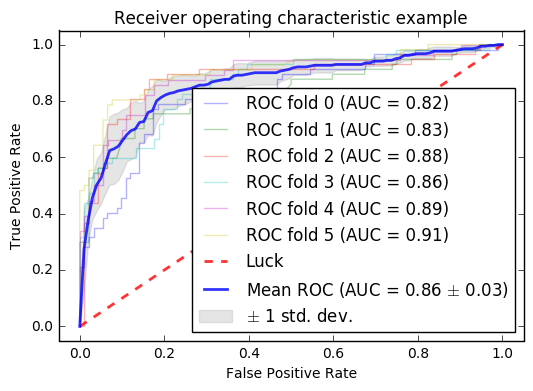

In [27]:
from sklearn.neural_network import MLPClassifier
model = MLPClassifier
tuned_parameters = [{'hidden_layer_sizes': [(10,), (100,), (10,10), (100,100)],
                     'activation': ['identity', 'logistic', 'tanh', 'relu'], 
                     'alpha': [1e-3, 1e-4, 1e-5], 
                    'solver': ['lbfgs']}]
run_steps(X, y, model, tuned_parameters)

## Ada Boost Classifier

Score on test using default settings:  0.809523809524
Scores for 5 fold CV:  [ 0.78089888  0.80337079  0.82022472  0.80337079  0.84180791]
Mean score for 5 fold CV:  0.809934615629
# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'n_estimators': 60, 'learning_rate': 1}

Grid scores on development set:

0.710 (+/-0.059) for {'n_estimators': 10, 'learning_rate': 0.01}
0.710 (+/-0.059) for {'n_estimators': 20, 'learning_rate': 0.01}
0.710 (+/-0.059) for {'n_estimators': 30, 'learning_rate': 0.01}
0.710 (+/-0.059) for {'n_estimators': 40, 'learning_rate': 0.01}
0.710 (+/-0.059) for {'n_estimators': 50, 'learning_rate': 0.01}
0.710 (+/-0.059) for {'n_estimators': 60, 'learning_rate': 0.01}
0.717 (+/-0.075) for {'n_estimators': 70, 'learning_rate': 0.01}
0.724 (+/-0.079) for {'n_estimators': 100, 'learning_rate': 0.01}
0.724 (+/-0.079) for {'n_estimators': 10, 'learning_rate': 0.1}
0.745 (+/-0.026) for {'n_estimators': 20, 'learning_rate': 0.1}
0.771 (

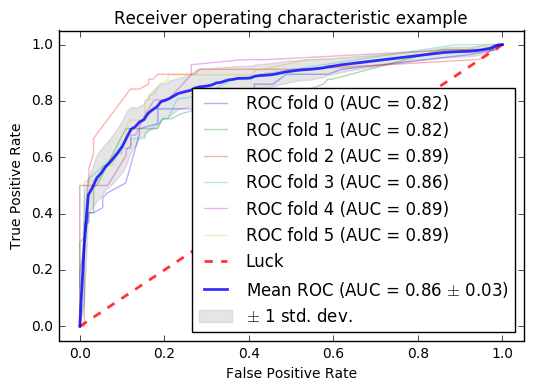

In [31]:
from sklearn.ensemble import AdaBoostClassifier
model = AdaBoostClassifier
tuned_parameters = [{'n_estimators': [10, 20, 30, 40, 50, 60, 70, 100],
                     'learning_rate': [0.01, 0.1, 1, 10]}]
run_steps(X, y, model, tuned_parameters)

## Gaussian Naive Bayes Classifier
There are no hyperparameters to optimize.

Score on test using default settings:  0.748299319728
Scores for 5 fold CV:  [ 0.70786517  0.76966292  0.76966292  0.76966292  0.75141243]
Mean score for 5 fold CV:  0.753653272393
# Tuning hyper-parameters for precision

Best parameters set found on development set:


Grid scores on development set:

0.866 (+/-0.061)

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.75      0.90      0.82       184
          1       0.75      0.49      0.59       110

avg / total       0.75      0.75      0.73       294


# Tuning hyper-parameters for recall

Best parameters set found on development set:


Grid scores on development set:

0.866 (+/-0.061)

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support



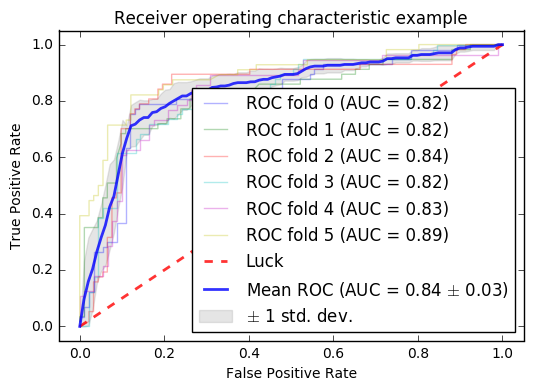

In [35]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
#model = model_f()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
model.fit(X_train, y_train)
print("Score on test using default settings: ", model.score(X_test, y_test))
scores = cross_val_score(model, X, y, cv = 5)
print("Scores for 5 fold CV: ", scores)
print("Mean score for 5 fold CV: ", np.mean(scores))

#tuned_parameters = [{'penalty': ['l1', 'l2'], 'C': [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100, 300, 1000]}]

scores = ['precision', 'recall', 'accuracy', 'f1', 'roc_auc']
#scores = ['recall', 'accuracy', 'f1', 'roc_auc']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    #clf = GridSearchCV(model, tuned_parameters, cv=5,
                   #scoring=score)
    #clf.fit(X_train, y_train)



    print("Best parameters set found on development set:")
    print()
    #print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    res = cross_val_score(model, X, y, cv = 5, scoring = score)
    means = np.mean(res)
    stds = np.std(res)
    #for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f)"
          % (mean, std * 2))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, model.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

#print("Best settings for ", scores[-1], ":", clf.best_params_)

cv = StratifiedKFold(n_splits=6)
classifier = model
#if (model_f == SVC):
#    classifier = model_f(**clf.best_params_, probability = True)
#else:
#    classifier = model_f(**clf.best_params_)
#X = X.as_matrix()
#y = y.as_matrix()

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(X, y):
    #print(X[train])
    probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
         label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
     label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
     label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
     lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
             label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


## Linear Discriminant Analysis
No hyperparameters to optimize.

/opt/intel/intelpython35/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/opt/intel/intelpython35/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/opt/intel/intelpython35/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/opt/intel/intelpython35/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/opt/intel/intelpython35/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/opt/intel/intelpython35/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warn

Score on test using default settings:  0.823129251701
Scores for 5 fold CV:  [ 0.8258427   0.81460674  0.81460674  0.79213483  0.85875706]
Mean score for 5 fold CV:  0.821189614677
# Tuning hyper-parameters for precision

Best parameters set found on development set:


Grid scores on development set:

0.866 (+/-0.061)

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.86      0.86      0.86       184
          1       0.76      0.76      0.76       110

avg / total       0.82      0.82      0.82       294


# Tuning hyper-parameters for recall

Best parameters set found on development set:


Grid scores on development set:

0.866 (+/-0.061)

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support



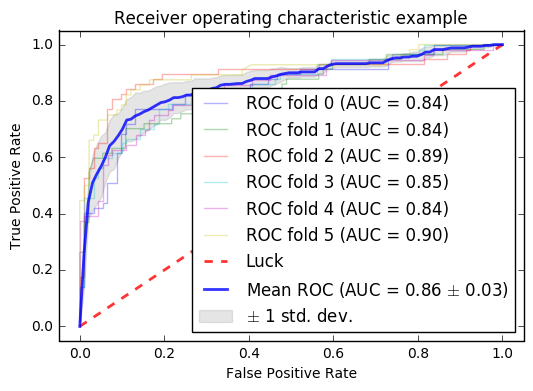

In [37]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
model = LinearDiscriminantAnalysis()
#model = model_f()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
model.fit(X_train, y_train)
print("Score on test using default settings: ", model.score(X_test, y_test))
scores = cross_val_score(model, X, y, cv = 5)
print("Scores for 5 fold CV: ", scores)
print("Mean score for 5 fold CV: ", np.mean(scores))

#tuned_parameters = [{'penalty': ['l1', 'l2'], 'C': [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100, 300, 1000]}]

scores = ['precision', 'recall', 'accuracy', 'f1', 'roc_auc']
#scores = ['recall', 'accuracy', 'f1', 'roc_auc']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    #clf = GridSearchCV(model, tuned_parameters, cv=5,
                   #scoring=score)
    #clf.fit(X_train, y_train)



    print("Best parameters set found on development set:")
    print()
    #print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    res = cross_val_score(model, X, y, cv = 5, scoring = score)
    means = np.mean(res)
    stds = np.std(res)
    #for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f)"
          % (mean, std * 2))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, model.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

#print("Best settings for ", scores[-1], ":", clf.best_params_)

cv = StratifiedKFold(n_splits=6)
classifier = model
#if (model_f == SVC):
#    classifier = model_f(**clf.best_params_, probability = True)
#else:
#    classifier = model_f(**clf.best_params_)
#X = X.as_matrix()
#y = y.as_matrix()

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(X, y):
    #print(X[train])
    probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
         label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
     label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
     label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
     lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
             label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## Quadratic Discriminant Analysis
No hyperparameters to optimize.

/opt/intel/intelpython35/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:695: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/opt/intel/intelpython35/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:695: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/opt/intel/intelpython35/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:695: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/opt/intel/intelpython35/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:695: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/opt/intel/intelpython35/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:695: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/opt/intel/intelpython35/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:695: UserWarning: Variables are collinear
  warnings.warn("

Score on test using default settings:  0.625850340136
Scores for 5 fold CV:  [ 0.61235955  0.62359551  0.62921348  0.70224719  0.61581921]
Mean score for 5 fold CV:  0.636646987875
# Tuning hyper-parameters for precision

Best parameters set found on development set:


Grid scores on development set:

0.866 (+/-0.061)

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.63      0.98      0.77       184
          1       0.50      0.03      0.05       110

avg / total       0.58      0.63      0.50       294


# Tuning hyper-parameters for recall

Best parameters set found on development set:


Grid scores on development set:

0.866 (+/-0.061)

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support



/opt/intel/intelpython35/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:695: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


             precision    recall  f1-score   support

          0       0.63      0.98      0.77       184
          1       0.50      0.03      0.05       110

avg / total       0.58      0.63      0.50       294




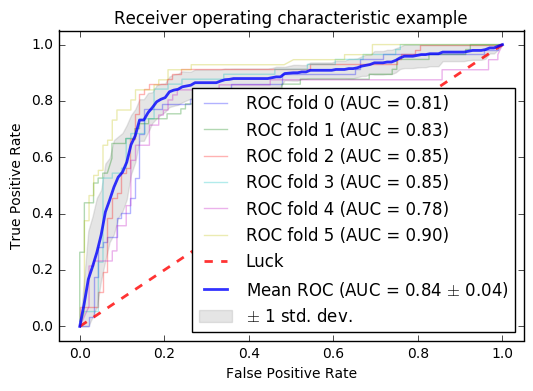

In [36]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
model = QuadraticDiscriminantAnalysis()
#model = model_f()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
model.fit(X_train, y_train)
print("Score on test using default settings: ", model.score(X_test, y_test))
scores = cross_val_score(model, X, y, cv = 5)
print("Scores for 5 fold CV: ", scores)
print("Mean score for 5 fold CV: ", np.mean(scores))

#tuned_parameters = [{'penalty': ['l1', 'l2'], 'C': [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100, 300, 1000]}]

scores = ['precision', 'recall', 'accuracy', 'f1', 'roc_auc']
#scores = ['recall', 'accuracy', 'f1', 'roc_auc']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    #clf = GridSearchCV(model, tuned_parameters, cv=5,
                   #scoring=score)
    #clf.fit(X_train, y_train)



    print("Best parameters set found on development set:")
    print()
    #print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    res = cross_val_score(model, X, y, cv = 5, scoring = score)
    means = np.mean(res)
    stds = np.std(res)
    #for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f)"
          % (mean, std * 2))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, model.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

#print("Best settings for ", scores[-1], ":", clf.best_params_)

cv = StratifiedKFold(n_splits=6)
classifier = model
#if (model_f == SVC):
#    classifier = model_f(**clf.best_params_, probability = True)
#else:
#    classifier = model_f(**clf.best_params_)
#X = X.as_matrix()
#y = y.as_matrix()

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(X, y):
    #print(X[train])
    probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
         label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
     label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
     label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
     lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
             label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## Dummy Classifier

Score on test using default settings:  0.496598639456
Scores for 5 fold CV:  [ 0.52808989  0.49438202  0.51123596  0.52247191  0.50282486]
Mean score for 5 fold CV:  0.511800926808
# Tuning hyper-parameters for precision



/opt/intel/intelpython35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/intel/intelpython35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/intel/intelpython35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/intel/intelpython35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/intel/intelpython35/lib/python3.5/site-

Best parameters set found on development set:

{'strategy': 'stratified'}

Grid scores on development set:

0.378 (+/-0.060) for {'strategy': 'stratified'}
0.000 (+/-0.000) for {'strategy': 'most_frequent'}
0.000 (+/-0.000) for {'strategy': 'prior'}
0.364 (+/-0.135) for {'strategy': 'uniform'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.66      0.66      0.66       184
          1       0.44      0.45      0.44       110

avg / total       0.58      0.58      0.58       294


# Tuning hyper-parameters for recall

Best parameters set found on development set:

{'strategy': 'uniform'}

Grid scores on development set:

0.313 (+/-0.112) for {'strategy': 'stratified'}
0.000 (+/-0.000) for {'strategy': 'most_frequent'}
0.000 (+/-0.000) for {'strategy': 'prior'}
0.535 (+/-0.157) for {'strategy': 'uniform'}

Detailed classificati

/opt/intel/intelpython35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/intel/intelpython35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/intel/intelpython35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/intel/intelpython35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/intel/intelpython35/lib/

Best parameters set found on development set:

{'strategy': 'uniform'}

Grid scores on development set:

0.395 (+/-0.135) for {'strategy': 'stratified'}
0.000 (+/-0.000) for {'strategy': 'most_frequent'}
0.000 (+/-0.000) for {'strategy': 'prior'}
0.400 (+/-0.141) for {'strategy': 'uniform'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.62      0.51      0.56       184
          1       0.37      0.48      0.42       110

avg / total       0.53      0.50      0.51       294


# Tuning hyper-parameters for roc_auc

Best parameters set found on development set:

{'strategy': 'most_frequent'}

Grid scores on development set:

0.487 (+/-0.076) for {'strategy': 'stratified'}
0.500 (+/-0.000) for {'strategy': 'most_frequent'}
0.500 (+/-0.000) for {'strategy': 'prior'}
0.500 (+/-0.000) for {'strategy': 'uniform'}

Detailed classifi

/opt/intel/intelpython35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


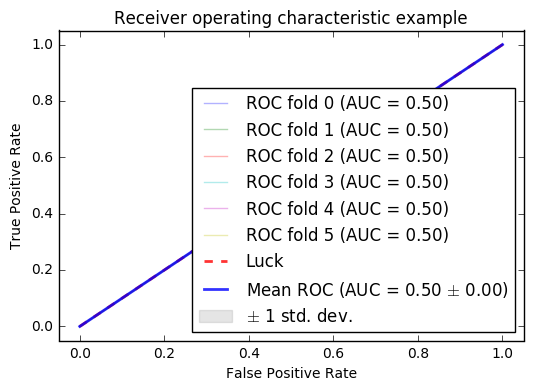

In [38]:
from sklearn.dummy import DummyClassifier
model = DummyClassifier
tuned_parameters = [{'strategy': ['stratified', 'most_frequent', 'prior', 'uniform']}]
run_steps(X, y, model, tuned_parameters)

In [668]:
test = pd.read_csv('test.csv')

In [669]:
X = test[keep]
X = pd.get_dummies(X)
model.predict(X)

KeyError: "['Title' 'ImputedAge'] not in index"